In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization,Concatenate
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc,ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import train_test_split
import numpy as np

In [7]:
# Define dataset path (Adjust according to your Kaggle dataset directory)
DATASET_PATH = "/Users/nana/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized"  # Modify based on your dataset path

In [8]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 5e-5

# Load all image file paths and labels
image_paths = []
labels = []

# Get all class folders
for class_name in sorted(os.listdir(DATASET_PATH)):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img))
            labels.append(class_name)

# Convert to DataFrame
df = pd.DataFrame({'filename': image_paths, 'class': labels})

# Split dataset into 70% Train, 10% Validation, 20% Test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=2/3, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Compute global mean and std for normalization
def compute_mean_std(df):
    mean = np.zeros(3)
    std = np.zeros(3)
    num_samples = 0

    for img_path in df['filename']:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img = np.array(img) / 255.0
        mean += np.mean(img, axis=(0, 1))
        std += np.std(img, axis=(0, 1))
        num_samples += 1

    mean /= num_samples
    std /= num_samples
    return mean, std

global_mean, global_std = compute_mean_std(train_df)
print(f"Global Mean: {global_mean}, Global Std: {global_std}")

Train: 1768, Validation: 253, Test: 506
Global Mean: [0.67199335 0.63888061 0.60427452], Global Std: [0.18336001 0.18296502 0.19337676]


In [12]:
df.head()

,filename,class
0,/Users/nana/.cache/kagglehub/datasets/feyzazke...,cardboard
1,/Users/nana/.cache/kagglehub/datasets/feyzazke...,cardboard
2,/Users/nana/.cache/kagglehub/datasets/feyzazke...,cardboard
3,/Users/nana/.cache/kagglehub/datasets/feyzazke...,cardboard
4,/Users/nana/.cache/kagglehub/datasets/feyzazke...,cardboard


In [9]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
)
train_datagen.mean = global_mean
train_datagen.std = global_std

# Only normalization for validation and testing
test_val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_val_datagen.mean = global_mean
test_val_datagen.std = global_std

# Load dataset using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1768 validated image filenames belonging to 6 classes.
Found 253 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [16]:
train_generator

In [10]:
# ✅ Define Input Layer
input_tensor = Input(shape=(224, 224, 3))

# ✅ Load MobileNetV2 as Feature Extractor
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)

# ✅ Fine-tune the last 30 layers for better adaptation
for layer in mobilenet.layers[:-30]:  
    layer.trainable = False  # Freeze earlier layers
for layer in mobilenet.layers[-30:]:
    layer.trainable = True  # Fine-tune the last layers
    
# ✅ Extract Features
x = GlobalAveragePooling2D()(mobilenet.output)

#x = Dropout(0.5)(efnet_out)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
num_classes = len(train_generator.class_indices)  # Get number of classes
out = Dense(num_classes, activation='softmax')(x)

# Create Hybrid Model
model = Model(inputs=input_tensor, outputs=out)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7,verbose = 1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/var/folders/sr/4rmb3s196mnb692nc04m_g1h0000gn/T/ipykernel_8238/2788097285.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,918,982 (11.14 MB)

 Trainable params: 2,186,374 (8.34 MB)

 Non-trainable params: 732,608 (2.79 MB)

In [11]:
with tf.device('/GPU:0'):
    # Train Model
    history = model.fit(train_generator, 
                        validation_data=val_generator, 
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_generator)//BATCH_SIZE,
                        validation_steps=len(val_generator)//BATCH_SIZE,
                        callbacks=[lr_scheduler,early_stopping])

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 689ms/step - accuracy: 0.2275 - loss: 2.7460 - val_accuracy: 0.3755 - val_loss: 1.5889 - learning_rate: 5.0000e-05
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - accuracy: 0.5368 - loss: 1.3546 - val_accuracy: 0.5889 - val_loss: 1.1873 - learning_rate: 5.0000e-05
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - accuracy: 0.6380 - loss: 1.0562 - val_accuracy: 0.6482 - val_loss: 1.0173 - learning_rate: 5.0000e-05
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 643ms/step - accuracy: 0.6982 - loss: 0.8933 - val_accuracy: 0.6798 - val_loss: 0.9525 - learning_rate: 5.0000e-05
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - accuracy: 0.7457 - loss: 0.7456 - val_accuracy: 0.6838 - val_loss: 0.9135 - learning_rate: 5.0000e-05
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 658ms/step - accuracy: 0.7939 - loss: 0.5833 - val_accuracy: 0.7036 - val_loss: 0.8454 - learning_rate: 5.0000e-05
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 646ms/step - accuracy

In [ ]:
# Save the model
model.save("hybrid_model_trashnet.h5")

In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("hybrid_model_trashnet.tflite", "wb") as f:
    f.write(tflite_model)
print("Model converted to TensorFlow Lite!")

Saved artifact at '/tmp/tmpam3eks16'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135585324123232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135585324723264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135585324722384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135585324725552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135585324726960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135585324726080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135586290374912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135586290375968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135586290372096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135586290374736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13558532472379

In [ ]:
# Evaluate Model
with tf.device('/GPU:0'):
    test_loss, test_accuracy = model.evaluate(test_generator)

# Generate Predictions
with tf.device('/GPU:0'):
    predictions = model.predict(test_generator)

# Convert Predictions to Class Labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes  # Get true labels

# Calculate Evaluation Metrics
precision = precision_score(y_true, y_pred, average='macro')
sensitivity = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Confusion Matrix & Specificity Calculation
cm = confusion_matrix(y_true, y_pred)
specificity_list = []
for i in range(cm.shape[0]):  # Loop through each class
    TN = cm.sum() - (cm.sum(axis=0)[i] + cm.sum(axis=1)[i] - cm[i, i])  # True Negatives
    FP = cm.sum(axis=0)[i] - cm[i, i]  # False Positives
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero
    specificity_list.append(specificity)
average_specificity = np.mean(specificity_list)

# Cohen's Kappa Score
kappa = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"F1 Score: {f1:.4f}")
for i, spec in enumerate(specificity_list):
    print(f"Class {i}: Specificity: {spec:.4f}")
print(f"Average Specificity: {average_specificity:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 998ms/step - accuracy: 0.8117 - loss: 0.7404
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 633ms/step
Test Accuracy: 0.8024
Precision: 0.8243
Sensitivity (Recall): 0.7549
F1 Score: 0.7632
Class 0: Specificity: 0.9929
Class 1: Specificity: 0.9729
Class 2: Specificity: 0.8467
Class 3: Specificity: 0.9922
Class 4: Specificity: 0.9633
Class 5: Specificity: 0.9937
Average Specificity: 0.9603
Cohen's Kappa Score: 0.7578


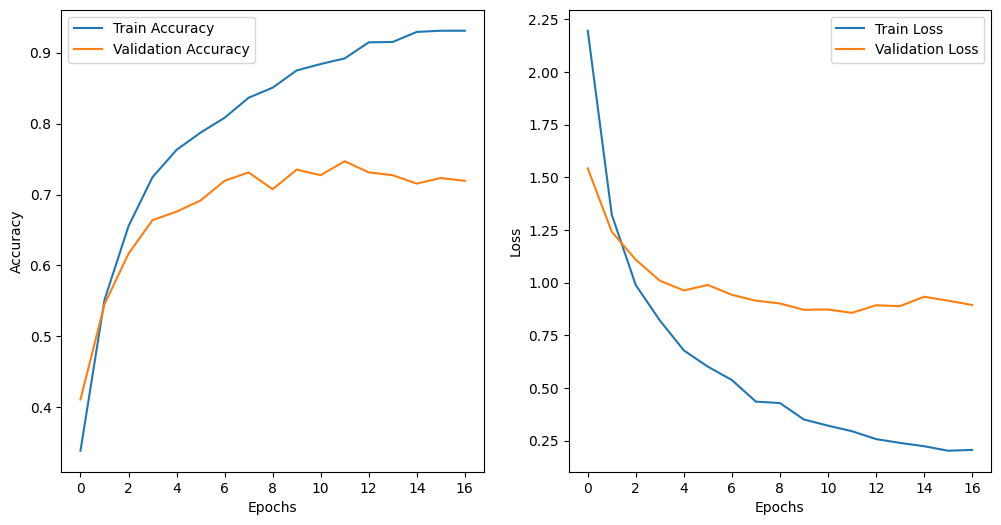

In [ ]:
# Plot Accuracy & Loss Graphs
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

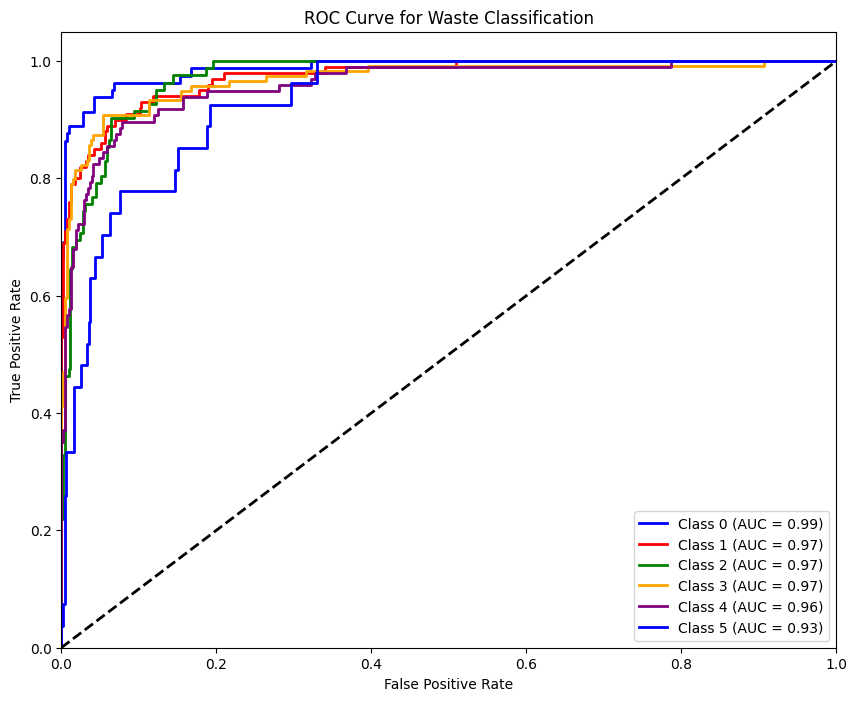

In [ ]:
# ROC Curve
y_true_binarized = label_binarize(y_true, classes=np.arange(len(cm)))  # Adjust based on class count
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(len(cm)), colors):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Waste Classification')
plt.legend(loc="lower right")
plt.show()

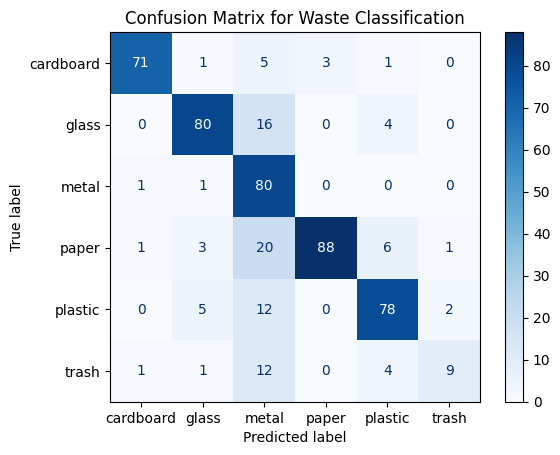

In [ ]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Waste Classification')
plt.show()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.88      0.92        81
       glass       0.88      0.80      0.84       100
       metal       0.55      0.98      0.70        82
       paper       0.97      0.74      0.84       119
     plastic       0.84      0.80      0.82        97
       trash       0.75      0.33      0.46        27

    accuracy                           0.80       506
   macro avg       0.82      0.75      0.76       506
weighted avg       0.84      0.80      0.81       506

